In [1]:
import json
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)

### Reading data & merging txt json objects to BG processed data

In [2]:
data_loc = "/Users/file/directory"
data_json_eop = []
i=0
with open(data_loc +"/BG_EOP_data_20220222.json", encoding= "UTF-8") as f:
    for line in f:
        i+=1
        d=json.loads(line)
        data_json_eop.append(d)
len(data_json_eop)

31306

In [3]:
data_json_aop = []
i=0
with open(data_loc +"/BG_AOP_data_20220228.json", encoding= "UTF-8") as f:
    for line in f:
        i+=1
        d=json.loads(line)
        data_json_aop.append(d)
len(data_json_aop)

144062

In [4]:
data_json = data_json_eop + data_json_aop
len(data_json)

175368

In [5]:
#collecting text info
text_info = []
for i,ten in enumerate(data_json):
    
    text_dict = {}
    text_dict["persistent_id"] = ten["persistentId"]
    
    try:
        text_dict["title"] = ten["title"] 
    except KeyError:
        text_dict["title"] = np.nan
        
    try:
        text_dict["description"] = ten["description"]
    except KeyError:
        text_dict["description"] = np.nan
        
    try:
        text_dict["personalRequirements"] = ten["personalRequirements"]
    except KeyError:
        text_dict["personalRequirements"] = np.nan
        
    try:
        text_dict["economicRequirements"] = ten["economicRequirements"]
    except KeyError:
        text_dict["economicRequirements"] = np.nan

    try:
        text_dict["technicalRequirements"] = ten["technicalRequirements"]
    except KeyError:
        text_dict["technicalRequirements"] = np.nan
        
    try:
        name = ''
        for b, crit in enumerate(ten["awardCriteria"]):
            try:
                if b >= 1:
                    name+= ", " + "{}) ".format(b+1) + str(crit["name"])
                else:
                    name = "{}) ".format(b+1) + crit["name"]
            except KeyError:
                pass
        
        text_dict["awardCriteria"] = name

    except KeyError:
        text_dict["awardCriteria"] = np.nan
    
    lots = []
    if "lots" in ten.keys():
        
        for v,lot in enumerate(ten["lots"]):     
            lot_text_dict = {}
            
            try:
                lot_text_dict["lot_id"] = lot["lotId"]
            except KeyError:
                lot_text_dict["lot_id"] = np.nan
                
            try:
                lot_text_dict["lot_title"] = lot["title"]
            except KeyError:
                lot_text_dict["lot_title"] = np.nan
                
            try:
                lot_text_dict["lot_description"] = lot["description"]
            except KeyError:
                lot_text_dict["lot_description"] = np.nan
                
            lots.append(lot_text_dict)
        
        
        
    text_dict["lots"] = lots
    
    text_info.append(text_dict)

In [6]:
text_df = pd.DataFrame(text_info)

In [7]:
text_df_contractlvl = text_df.explode("lots").reset_index(drop = True)

In [8]:
text_df_contractlvl = pd.concat(
    [text_df_contractlvl.drop(['lots'], axis=1), 
     text_df_contractlvl['lots'].apply(pd.Series)], axis=1)

text_df_contractlvl.drop(0, axis = 1, inplace = True)

In [9]:
data_loc = "/Users/file/directory/bg"
data_processed = pd.read_csv(data_loc + "/bg_cri_20220317_processed.csv", low_memory = False)

In [10]:
data_proc_wtext = data_processed.merge(
    text_df_contractlvl.loc[:, ~text_df_contractlvl.columns.isin(["lot_title", "title"])], 
    on = ["persistent_id", "lot_id"], 
    how = "left").drop_duplicates(subset = "bid_id")

### Text fields availablility

In [11]:
mis_title_shr = (len(data_proc_wtext[(data_proc_wtext["tender_title"].isna())]) /
                     len(data_proc_wtext))

mis_desc_shr = (len(data_proc_wtext[(data_proc_wtext["description"].isna())]) /
                     len(data_proc_wtext))

mis_persreq_shr = (len(data_proc_wtext[(data_proc_wtext["personalRequirements"].isna())]) /
                     len(data_proc_wtext))

mis_ecoreq_shr = (len(data_proc_wtext[(data_proc_wtext["economicRequirements"].isna())]) /
                     len(data_proc_wtext))

mis_techreq_shr = (len(data_proc_wtext[(data_proc_wtext["technicalRequirements"].isna())]) /
                     len(data_proc_wtext))

mis_awcrit_shr = (len(data_proc_wtext[(data_proc_wtext["awardCriteria"].isna())]) /
                     len(data_proc_wtext))

mis_lottitle_shr = (len(data_proc_wtext[(data_proc_wtext["lot_title"].isna())]) /
                     len(data_proc_wtext))

mis_lotdesc_shr = (len(data_proc_wtext[(data_proc_wtext["lot_description"].isna())]) /
                     len(data_proc_wtext))

In [12]:
mis_title_shr_all = (len(data_proc_wtext[(data_proc_wtext["tender_title"].isna()) | 
                                     (data_proc_wtext["tender_title"] == "") |
                                     (data_proc_wtext["tender_title"] == " ") | 
                                     (data_proc_wtext["tender_title"]== "НЕ") |
                                     (data_proc_wtext["tender_title"] == "не") |
                                     (data_proc_wtext["tender_title"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват"])) |
                                     (data_proc_wtext["tender_title"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["tender_title"]) < 5)]) /
                 len(data_proc_wtext))

mis_desc_shr_all = (len(data_proc_wtext[(data_proc_wtext["description"].isna()) | 
                                     (data_proc_wtext["description"] == "") |
                                     (data_proc_wtext["description"] == " ") | 
                                     (data_proc_wtext["description"]== "НЕ") |
                                     (data_proc_wtext["description"] == "не") |
                                     (data_proc_wtext["description"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват"])) | 
                                     (data_proc_wtext["description"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["description"]) < 5)]) /
                 len(data_proc_wtext))

mis_persreq_shr_all = (len(data_proc_wtext[(data_proc_wtext["personalRequirements"].isna()) | 
                                     (data_proc_wtext["personalRequirements"] == "") |
                                     (data_proc_wtext["personalRequirements"] == " ") | 
                                     (data_proc_wtext["personalRequirements"]== "НЕ") |
                                     (data_proc_wtext["personalRequirements"] == "не") |
                                     (data_proc_wtext["personalRequirements"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват",
                                                                            "Не се изисква"])) | 
                                     (data_proc_wtext["personalRequirements"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["personalRequirements"]) < 5)]) /
                 len(data_proc_wtext))

mis_ecoreq_shr_all = (len(data_proc_wtext[(data_proc_wtext["economicRequirements"].isna()) | 
                                     (data_proc_wtext["economicRequirements"] == "") |
                                     (data_proc_wtext["economicRequirements"] == " ") | 
                                     (data_proc_wtext["economicRequirements"]== "НЕ") |
                                     (data_proc_wtext["economicRequirements"] == "не") |
                                     (data_proc_wtext["economicRequirements"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват",
                                                                            "Не се изисква"])) | 
                                     (data_proc_wtext["economicRequirements"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["economicRequirements"]) < 5)]) /
                 len(data_proc_wtext))

mis_techreq_shr_all = (len(data_proc_wtext[(data_proc_wtext["technicalRequirements"].isna()) | 
                                     (data_proc_wtext["technicalRequirements"] == "") |
                                     (data_proc_wtext["technicalRequirements"] == " ") | 
                                     (data_proc_wtext["technicalRequirements"]== "НЕ") |
                                     (data_proc_wtext["technicalRequirements"] == "не") |
                                     (data_proc_wtext["technicalRequirements"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват",
                                                                            "Не се изисква"])) | 
                                     (data_proc_wtext["technicalRequirements"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["technicalRequirements"]) < 5)]) /
                 len(data_proc_wtext))

mis_awcrit_shr_all = (len(data_proc_wtext[(data_proc_wtext["awardCriteria"].isna()) | 
                                     (data_proc_wtext["awardCriteria"] == "") |
                                     (data_proc_wtext["awardCriteria"] == " ") | 
                                     (data_proc_wtext["awardCriteria"]== "НЕ") |
                                     (data_proc_wtext["awardCriteria"] == "не") |
                                     (data_proc_wtext["awardCriteria"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват",
                                                                            "Не се изисква"])) | 
                                     (data_proc_wtext["awardCriteria"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["awardCriteria"]) < 5)]) /
                 len(data_proc_wtext))

mis_lottitle_shr_all = (len(data_proc_wtext[(data_proc_wtext["lot_title"].isna()) | 
                                     (data_proc_wtext["lot_title"] == "") |
                                     (data_proc_wtext["lot_title"] == " ") | 
                                     (data_proc_wtext["lot_title"]== "НЕ") |
                                     (data_proc_wtext["lot_title"] == "не") |
                                     (data_proc_wtext["lot_title"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват",
                                                                            "Не се изисква"])) | 
                                     (data_proc_wtext["lot_title"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["lot_title"]) < 5)]) /
                 len(data_proc_wtext))

mis_lotdesc_shr_all = (len(data_proc_wtext[(data_proc_wtext["lot_description"].isna()) | 
                                     (data_proc_wtext["lot_description"] == "") |
                                     (data_proc_wtext["lot_description"] == " ") | 
                                     (data_proc_wtext["lot_description"]== "НЕ") |
                                     (data_proc_wtext["lot_description"] == "не") |
                                     (data_proc_wtext["lot_description"].isin(["няма изисквания", 
                                                                            "Няма изисквания.",
                                                                            "Няма изискване.",
                                                                            "няма", 
                                                                            "Не се изискват.",
                                                                            "Възложителят не поставя изисквания.",
                                                                            "не се изисква",
                                                                            "Не се изисква.",
                                                                            "не се изискват",
                                                                            "Не се изисква"])) | 
                                     (data_proc_wtext["lot_description"].isin(
                                         ["Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "Изискуеми документи и информация: не Минимални изисквания: не",
                                        "Изискуеми документи и информация: не се изискват Минимални изисквания: не се изискват",
                                        "Изискуеми документи и информация: Не се изискват Минимални изисквания: Не се изискват",
                                        "Възложителят не поставя условия за икономическо и финансово състояние",
                                        "Възложителят не поставя изисквания за икономическо и финансово състояние на участниците.",
                                        "Изискуеми документи и информация: Няма Минимални изисквания: Няма",
                                        "Изискуеми документи и информация: няма Минимални изисквания: няма",
                                        "няма поставени изисквания",
                                        "Договор",
                                        ":",
                                        "договор"])) |
                                     (len(data_proc_wtext["lot_description"]) < 5)]) /
                 len(data_proc_wtext))

In [13]:
missing_txt_fields_n = pd.DataFrame({"missing_share": [mis_title_shr, mis_desc_shr, mis_persreq_shr, 
                     mis_ecoreq_shr, mis_techreq_shr, mis_awcrit_shr,
                     mis_lottitle_shr, mis_lotdesc_shr], "text_obj_name": ["Title", "Description","Personal reqs.", 
                     "Economic reqs.", "Technical reqs.", "Award crits.",
                     "Lot title", "Lot desc."], "type": "narrow"})

In [14]:
missing_txt_fields_b = pd.DataFrame({"missing_share": [mis_title_shr_all, mis_desc_shr_all, mis_persreq_shr_all, 
                     mis_ecoreq_shr_all, mis_techreq_shr_all, mis_awcrit_shr_all,
                     mis_lottitle_shr_all, mis_lotdesc_shr_all],"text_obj_name": ["Title", "Description","Personal reqs.", 
                     "Economic reqs.", "Technical reqs.", "Award crits.",
                     "Lot title", "Lot desc."], "type": "broad"})

In [15]:
missing_txt_fields_all = pd.concat([missing_txt_fields_n, missing_txt_fields_b], ignore_index=True)

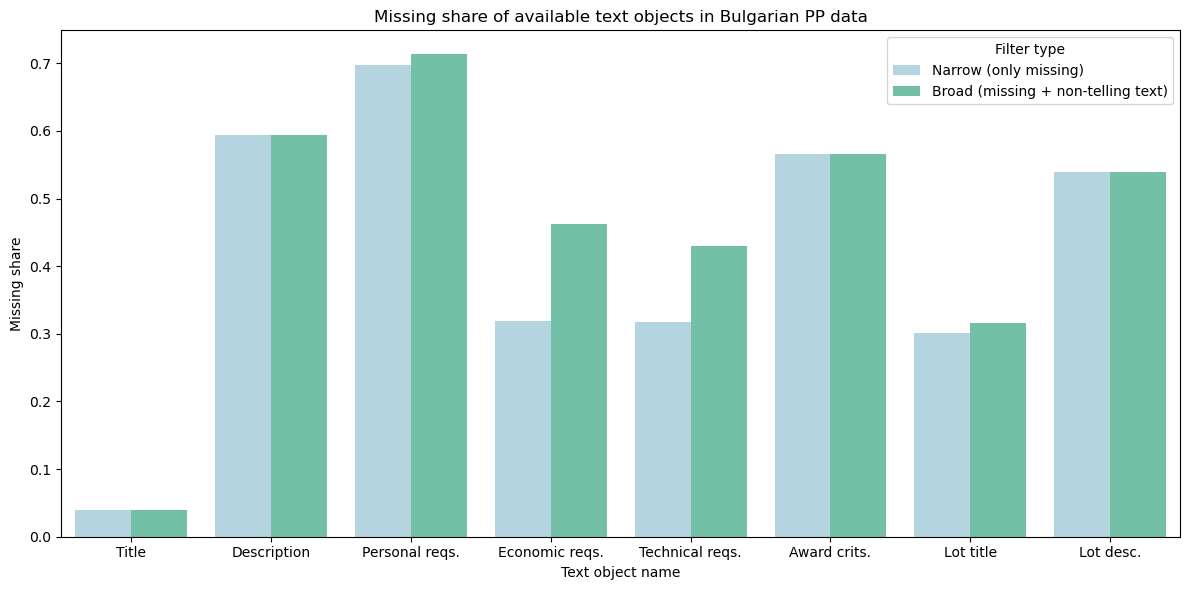

In [16]:
fig, axes = plt.subplots(1,1, figsize = [12,6])

ax = sns.barplot(x = missing_txt_fields_all["text_obj_name"], 
                 y = missing_txt_fields_all["missing_share"],
                 hue = missing_txt_fields_all["type"],
                 palette = ["lightblue", "mediumaquamarine"])

ax.set_ylabel("Missing share")
ax.set_xlabel("Text object name")
ax.set_title("Missing share of available text objects in Bulgarian PP data")
h, l = ax.get_legend_handles_labels()
labels = ["Narrow (only missing)", "Broad (missing + non-telling text)"]
ax.legend(h, labels, title="Filter type")
plt.tight_layout();
plt.savefig('missing_share.png')

In [17]:
text_fields = ["tender_title",
"description",
"personalRequirements",
"economicRequirements",
"technicalRequirements",
"awardCriteria",
"lot_title",
"lot_description"]

missing_by_year = pd.DataFrame({"tender_year": np.arange(2007,2020,1)})

for field in text_fields:
    
    not_av = (data_proc_wtext[(data_proc_wtext[field].isna())]
              .groupby("tender_year")["lot_id"]
              .count()
              .to_frame()
              .reset_index()
              .rename(columns = {"lot_id": field + "_miss"}))
    
    all_ = (data_proc_wtext
              .groupby("tender_year")["lot_id"]
              .count()
              .to_frame()
              .reset_index()
              .rename(columns = {"lot_id": field + "_all"}))
    
    field_merged = not_av.merge(all_, on = "tender_year")
    field_merged[field + "_missing_share"] = field_merged[field + "_miss"]/field_merged[field + "_all"]
    
    missing_by_year = missing_by_year.merge(field_merged[["tender_year", field + "_missing_share"]], on = "tender_year")
    

In [18]:
missing_by_year

,tender_year,tender_title_missing_share,description_missing_share,personalRequirements_missing_share,economicRequirements_missing_share,technicalRequirements_missing_share,awardCriteria_missing_share,lot_title_missing_share,lot_description_missing_share
0,2007,0.107744,0.699004,0.699004,0.158997,0.158997,0.724845,0.236951,0.671875
1,2008,0.109451,0.630681,0.630681,0.166906,0.166791,0.724045,0.268429,0.652341
2,2009,0.054815,0.704974,0.704974,0.146384,0.146314,0.664974,0.146526,0.681693
3,2010,0.028369,0.601742,0.601742,0.117831,0.117831,0.616028,0.025172,0.531261
4,2011,0.029099,0.658813,0.658936,0.145740,0.145740,0.452415,0.025715,0.551277
5,2012,0.038581,0.626701,0.626990,0.156113,0.156113,0.413552,0.056805,0.497636
6,2013,0.028839,0.865878,0.870629,0.446551,0.446551,0.423223,0.238455,0.573926
7,2014,0.034538,0.937266,0.952322,0.538872,0.538872,0.347933,0.212611,0.584999
8,2015,0.039226,0.914964,0.985370,0.576921,0.576921,0.338362,0.264801,0.600786
9,2016,0.046587,0.688943,0.927468,0.586474,0.586474,0.440497,0.424816,0.565148


In [19]:
def get_av_length(data,col,name):
    return {"txt_obj_name": name,"Av_text_length" : round(data[col].str.len().mean())}

In [20]:
# Initialize av_text_length as an empty DataFrame
av_text_length = pd.DataFrame()

col_names = ["Title", "Description", "Personal reqs.", "Economic reqs.", 
             "Technical reqs.", "Award crits.", "Lot title", "Lot desc."]
cols = ["tender_title", "description", "personalRequirements", "economicRequirements",
        "technicalRequirements", "awardCriteria", "lot_title", "lot_description"]

for col, name in zip(cols, col_names):
    # Convert the result of get_av_length to a DataFrame before concatenating
    new_data = pd.DataFrame([get_av_length(data_proc_wtext, col, name)])
    
    # Concatenate the new DataFrame with the existing one
    av_text_length = pd.concat([av_text_length, new_data], ignore_index=True)

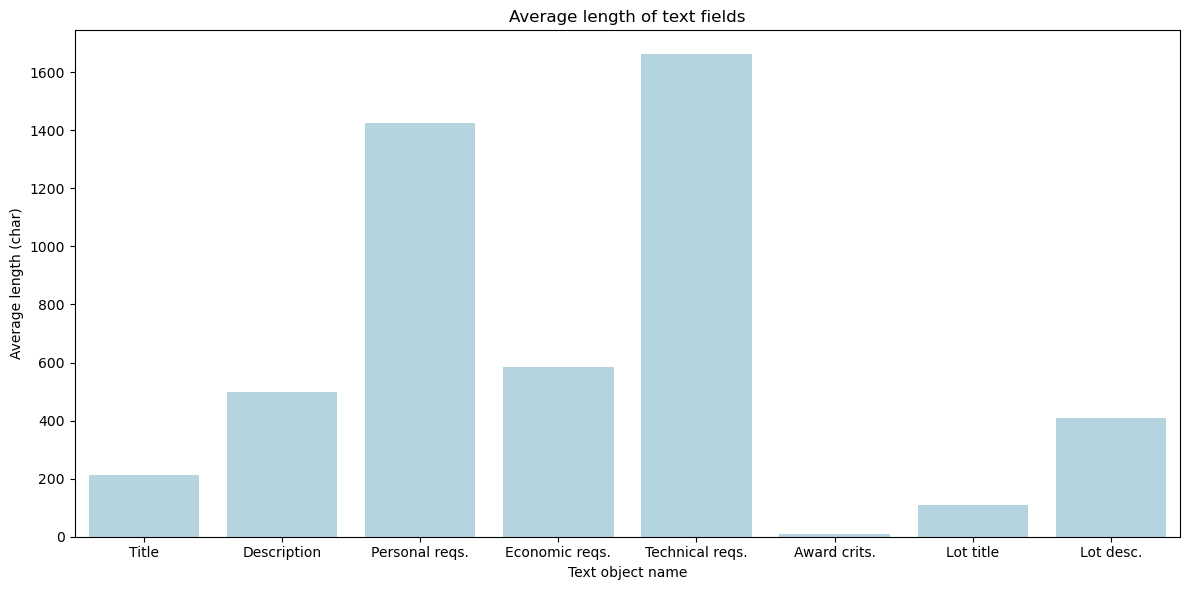

In [21]:
fig, axes = plt.subplots(1,1, figsize = [12,6])

#av_text_length.sort_value(by = "Av_text_length", inplace = True)

ax = sns.barplot(x = av_text_length["txt_obj_name"], 
                 y = av_text_length["Av_text_length"],
                 color = "lightblue")

ax.set_ylabel("Average length (char)")
ax.set_xlabel("Text object name")
ax.set_title("Average length of text fields");

plt.tight_layout();
plt.savefig('avg_text_length.png')

In [22]:
cols = ["tender_title","description","personalRequirements","economicRequirements",
            "technicalRequirements","awardCriteria","lot_title","lot_description"]

text_length = pd.DataFrame({"tender_year": np.arange(2007,2020,1)})

for col in cols:
    length = (data_proc_wtext
              .groupby("tender_year")[col]
              .apply(lambda x: np.mean(x.str.len()))
              .to_frame()
              .reset_index())
    
    text_length = text_length.merge(length, on = "tender_year")

In [23]:
length = (data_proc_wtext
              .groupby("tender_year")["awardCriteria"]
              .apply(lambda x: np.mean(x.str.len()))
              .to_frame()
              .reset_index())

In [24]:
text_length

,tender_year,tender_title,description,personalRequirements,economicRequirements,technicalRequirements,awardCriteria,lot_title,lot_description
0,2007,146.700568,329.100114,827.504278,361.758167,724.349122,8.000000,79.437669,147.699110
1,2008,177.790258,372.666615,917.606254,417.082207,849.907599,8.000000,83.933951,143.020988
2,2009,181.844305,406.377331,1062.355811,532.556281,1155.456078,8.000000,101.777484,162.284574
3,2010,204.951827,455.169628,2387.142296,721.789697,1558.437572,8.000000,112.677158,165.326560
4,2011,219.107337,490.627660,2014.850649,791.981348,2000.990782,8.000000,119.853760,182.782972
5,2012,236.334533,532.737834,2367.831633,1025.902959,2491.988587,8.000000,121.877591,203.485937
6,2013,261.368622,494.698548,2610.488432,1229.063181,2850.216928,8.000000,113.440327,273.373662
7,2014,251.117858,353.037818,3062.019139,1294.467003,2868.220342,8.000000,109.856588,275.560466
8,2015,265.810516,402.348925,3049.053125,371.289713,2738.781500,8.000000,113.574405,285.929111
9,2016,302.985766,458.807149,1285.495283,268.377551,2553.240485,8.000000,123.865768,443.423289


### Finding green procurements with keywords

In [25]:
data_loc = "/Users/file/directory"

In [26]:
keywords = pd.read_csv(data_loc + "/green_procurement_keywords.csv")
stopwords = pd.read_csv(data_loc + "/bulgarian_stopwords.txt").rename(columns = {'а': "stopwords"})

In [27]:
stopwords_pattern = ' | '.join(stopwords["stopwords"])

In [28]:
#removing stopwords from keywords and text columns
def stop_words(data,col, stopwords):
    
    #Pre-cleaning
    data[col + "_clean"] = data[col].str.lower().str.replace('\W', " ", regex = True) #spec char.
    #data[col + "_clean"] = data[col + "_clean"].str.replace('\d+', "", regex = True) #nums.
    
    #stop words
    data[col + "_clean"] = data[col + "_clean"].str.replace(stopwords_pattern, " ", regex=True)
    
    #Remove double spaces & tabs
    data[col + "_clean"] = data[col + "_clean"].str.lower().str.replace('  ', " ", regex = False)
    data[col + "_clean"] = data[col + "_clean"].str.lower().str.replace('\t', " ", regex = True)
    
    return data

In [29]:
cols = ["tender_title","description","personalRequirements","economicRequirements",
            "technicalRequirements","awardCriteria","lot_title","lot_description"]

data_proc_wcleantext = data_proc_wtext.copy()
for col in cols:
    data_proc_wcleantext = stop_words(data_proc_wcleantext, col, stopwords)

In [30]:
keywords_wcleantext = stop_words(keywords, "green_word_bg", stopwords)
keywords_pattern = ' | '.join(keywords_wcleantext["green_word_bg_clean"])

In [31]:
#Creating green procurement dummies
def green_dummies(data, col, keywords):

    data["green_pp_dummy_{}".format(col.replace("_clean",""))] = np.where(
        (data[col].str.contains(keywords)) &
        ~(data[col].isna()),1,0)
    return data

In [32]:
cols_clean = ["tender_title_clean","description_clean","personalRequirements_clean","economicRequirements_clean",
            "technicalRequirements_clean","awardCriteria_clean","lot_title_clean","lot_description_clean"]

for col in cols_clean:
    data_proc_wcleantext = green_dummies(data_proc_wcleantext, col, keywords_pattern)

In [33]:
data_proc_wcleantext["green_pp_dummy"] = np.where(
    data_proc_wcleantext[data_proc_wcleantext.columns[-len(cols_clean):]].sum(axis = 1) > 0, 
    1,0)

In [34]:
len(data_proc_wcleantext[data_proc_wcleantext["green_pp_dummy"] == 1])

13293

In [38]:
data_proc_wcleantext["main_cpv_full"] = data_proc_wcleantext["tender_cpvs"].str.split(",").str[0]
data_proc_wcleantext["main_cpv_4"] = data_proc_wcleantext["tender_cpvs"].str.split(",").str[0].str[:4]
data_proc_wcleantext["main_cpv_div"] = data_proc_wcleantext["tender_cpvs"].str.split(",").str[0].str[:2]

In [39]:
green_cpvs = ["42914000","90514000","45213270","90715270","71314300", 
"45261410","45321000", "90730000","90715000","60651300","45262640","71313000",
"80540000","90700000","31121300","09330000","45261215","45251141"]

green_cpvs = [i.rstrip("0") for i in green_cpvs]

In [40]:
data_proc_wcleantext["green_pp_dummy"] = (np.where(
    data_proc_wcleantext["main_cpv_full"]
    .str
    .startswith(
        tuple(green_cpvs), 
        na=False), 
    1, 
    data_proc_wcleantext["green_pp_dummy"]))

In [41]:
data_proc_wcleantext = data_proc_wcleantext[(data_proc_wcleantext["tender_year"] >= 2011) & 
                                           (data_proc_wcleantext["tender_year"] <= 2019)]

In [42]:
len(data_proc_wcleantext[data_proc_wcleantext["green_pp_dummy"] == 1])

11073

In [43]:
len(data_proc_wcleantext[data_proc_wcleantext["green_pp_dummy"] == 1].drop_duplicates("tender_id"))

6426

### Figure 2: Yearly contract value and volume distribution of Green Public Procurement

In [44]:
fig1_d = (data_proc_wcleantext
          .groupby(["tender_year", "green_pp_dummy"])
          .agg({"lot_id":"count", "bid_price": sum})
          .reset_index()
          .pivot(index = "tender_year", columns = "green_pp_dummy", values = ["lot_id", "bid_price"])
          .reset_index())

fig1_d = fig1_d[(fig1_d["tender_year"]>=2011) & (fig1_d["tender_year"]<=2019)].reset_index(drop = True)
fig1_d.columns = ["tender_year", "count_other", "count_green", 'contract_value_other', 'contract_value_green']

In [45]:
fig1_d["volume_share"] = fig1_d["count_green"]/(fig1_d["count_green"]+fig1_d["count_other"])
fig1_d["value_share"] = fig1_d["contract_value_green"]/(fig1_d["contract_value_green"]+fig1_d["contract_value_other"])
fig1_d["contract_value_green_m"] = fig1_d["contract_value_green"]/1000000

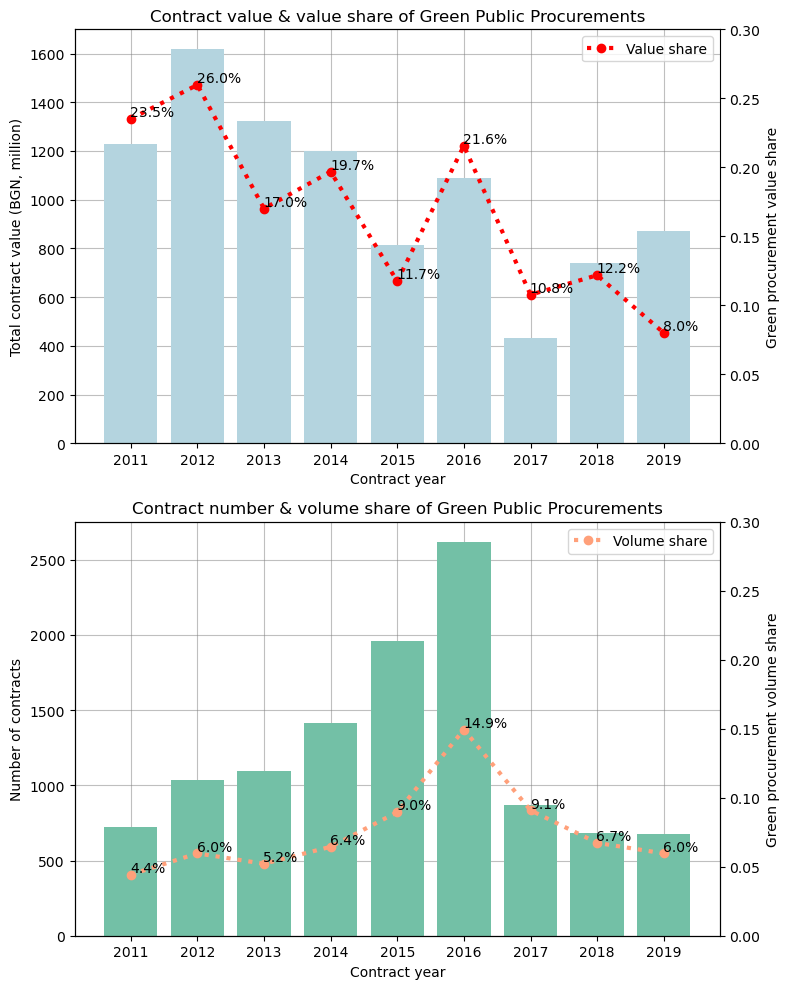

In [49]:
fig, ax = plt.subplots(2,1, figsize = [8,10])
f1 = sns.barplot(
    x = "tender_year",
    y = "contract_value_green_m",
    data = fig1_d, 
    color = "lightblue", ax = ax[0])

#f1.set_ylim(0,80)
f1.set_ylabel("Total contract value (BGN, million)")
f1.set_xlabel("Contract year")
f1.set_title("Contract value & value share of Green Public Procurements")

f1.set_axisbelow(True)
f1.yaxis.grid(color='gray', alpha = 0.5)
f1.set_axisbelow(True)
f1.xaxis.grid(color='gray', alpha = 0.5)

f1.spines["right"].set_visible(False)

f2 = f1.twinx()
f2.grid(False)

f2.plot(fig1_d["value_share"],
        ':o',
        color = "red", 
        linewidth=3,
        label = "Value share")

f2.set_ylim(0,0.3)
f2.legend()
f2.set_ylabel("Green procurement value share")

loc_x = 0
for i in fig1_d["value_share"]:
    f2.annotate(str(round(i*100,1)) + "%", xy = (loc_x-0.01,i+0.002))
    #ax.annotate(str(round(z*100)) + "%", xy = (loc_x-0.4,z-0.02))
    loc_x += 1

f3 = sns.barplot(
    x = "tender_year",
    y = "count_green",
    data = fig1_d, 
    color = "mediumaquamarine", ax = ax[1])

#f3.set_ylim(0,2000)
f3.set_ylabel("Number of contracts")
f3.set_xlabel("Contract year")
f3.set_title("Contract number & volume share of Green Public Procurements")

f3.set_axisbelow(True)
f3.yaxis.grid(color='gray', alpha = 0.5)
f3.set_axisbelow(True)
f3.xaxis.grid(color='gray', alpha = 0.5)

f4 = f3.twinx()
f4.grid(False)

f4.plot(fig1_d["volume_share"],
        ':o',
        color = "lightsalmon", 
        linewidth=3,
        label = "Volume share")

f4.set_ylim(0,0.3)
f4.legend()
f4.set_ylabel("Green procurement volume share")

loc_x = 0
for i in fig1_d["volume_share"]:
    f4.annotate(str(round(i*100,1)) + "%", xy = (loc_x-0.01,i+0.002))
    #ax.annotate(str(round(z*100)) + "%", xy = (loc_x-0.4,z-0.02))
    loc_x += 1

plt.tight_layout();

plt.savefig('yearly_dist.png')

***Filtering  off energy efficiency***

In [50]:
keywords_robust1 = keywords[keywords["green_word_eng"] != "energy efficiency"]

In [51]:
cols = ["tender_title","description","personalRequirements","economicRequirements",
            "technicalRequirements","awardCriteria","lot_title","lot_description"]

data_proc_wcleantext_r1 = data_proc_wtext.copy()
for col in cols:
    data_proc_wcleantext_r1 = stop_words(data_proc_wcleantext_r1, col, stopwords)

In [52]:
keywords_wcleantext_r1 = stop_words(keywords_robust1, "green_word_bg", stopwords)
keywords_pattern_r1 = ' | '.join(keywords_wcleantext_r1["green_word_bg_clean"])

/var/folders/zb/jpk18xf50b57s6s50g3z6k900000gn/T/ipykernel_4449/4216104641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + "_clean"] = data[col].str.lower().str.replace('\W', " ", regex = True) #spec char.
/var/folders/zb/jpk18xf50b57s6s50g3z6k900000gn/T/ipykernel_4449/4216104641.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + "_clean"] = data[col + "_clean"].str.replace(stopwords_pattern, " ", regex=True)
/var/folders/zb/jpk18xf50b57s6s50g3z6k900000gn/T/ipykernel_4449/42161046

In [53]:
cols_clean = ["tender_title_clean","description_clean","personalRequirements_clean","economicRequirements_clean",
            "technicalRequirements_clean","awardCriteria_clean","lot_title_clean","lot_description_clean"]

for col in cols_clean:
    data_proc_wcleantext_r1 = green_dummies(data_proc_wcleantext_r1, col, keywords_pattern_r1)

In [54]:
data_proc_wcleantext_r1["green_pp_dummy"] = np.where(
    data_proc_wcleantext_r1[data_proc_wcleantext_r1.columns[-len(cols_clean):]].sum(axis = 1) > 0, 
    1,0)

In [55]:
len(data_proc_wcleantext_r1[data_proc_wcleantext_r1["green_pp_dummy"] == 1])

8673

### Additional CPV based filtering

In [56]:
data_proc_wcleantext_r1["main_cpv_full"] = data_proc_wcleantext_r1["tender_cpvs"].str.split(",").str[0]
data_proc_wcleantext_r1["main_cpv_4"] = data_proc_wcleantext_r1["tender_cpvs"].str.split(",").str[0].str[:4]
data_proc_wcleantext_r1["main_cpv_div"] = data_proc_wcleantext_r1["tender_cpvs"].str.split(",").str[0].str[:2]

In [57]:
green_cpvs = ["42914000","90514000","45213270","90715270","71314300", 
"45261410","45321000", "90730000","90715000","60651300","45262640","71313000",
"80540000","90700000","31121300","09330000","45261215","45251141"]

green_cpvs = [i.rstrip("0") for i in green_cpvs]

In [58]:
data_proc_wcleantext_r1["green_pp_dummy"] = (np.where(
    data_proc_wcleantext_r1["main_cpv_full"]
    .str
    .startswith(
        tuple(green_cpvs), 
        na=False), 
    1, 
    data_proc_wcleantext_r1["green_pp_dummy"]))

In [59]:
#Year filt
data_proc_wcleantext_r1 = data_proc_wcleantext_r1[(data_proc_wcleantext_r1["tender_year"] >= 2011) & 
                                           (data_proc_wcleantext_r1["tender_year"] <= 2019)]

In [60]:
len(data_proc_wcleantext_r1[data_proc_wcleantext_r1["green_pp_dummy"] == 1])

6715

### Green keyword and CPV occurences

In [61]:
cols_clean = ["tender_title_clean","description_clean","personalRequirements_clean","economicRequirements_clean",
            "technicalRequirements_clean","awardCriteria_clean","lot_title_clean","lot_description_clean"]

In [62]:
keyword_freq = pd.DataFrame({"keywords": list(keywords_wcleantext["green_word_bg_clean"])})
keyword_freq = keyword_freq.set_index("keywords")
for col in cols_clean:
    keyword_freq[col] = np.nan
    for keyword in list(keywords_wcleantext["green_word_bg_clean"]):
        count = data_proc_wcleantext[col].str.count(keyword).sum()
        keyword_freq.loc[keyword, col] = count

In [63]:
keyword_freq["total_Freq"] = keyword_freq[keyword_freq.columns[-len(cols_clean):]].sum(axis = 1)
keyword_freq.reset_index(inplace = True)

In [64]:
keyword_freq = (keywords[["green_word_eng", "green_word_bg_clean"]]
            .merge(keyword_freq, left_on = "green_word_bg_clean", right_on = "keywords")
            .drop(columns = "green_word_bg_clean"))

In [65]:
keyword_freq.sort_values(by = "total_Freq", inplace = True, ascending = False)

In [66]:
green_cols = [col for col in data_proc_wcleantext.columns if "green_pp" in col]
green_cols_clean = ["Title", "Description","Personal reqs.", 
                     "Economic reqs.", "Technical reqs.", "Award crits.",
                     "Lot title", "Lot desc.", "All"]
dummy_data = pd.DataFrame({"colname": green_cols, "colname_clean": green_cols_clean})
dummy_data.set_index("colname", inplace = True)
for col in green_cols:
    freq = data_proc_wcleantext[col].sum()
    dummy_data.loc[col,"freq"] = freq
    

dummy_data.sort_values(by = "freq", ascending = False, inplace = True)

In [67]:
green_cpv_dict = {"42914": "Recycling equipment",
"90514": "Refuse recycling services",
"4521327": "Construction works for recycling station",
"9071527": "Recycling plant site investigation",
"713143": "Energy-efficiency consultancy services",
"4526141": "Roof insulation work",
"45321": "Thermal insulation work",
"9073": "Pollution tracking and monitoring and rehabilitation",
"90715": "Pollution investigation services",
"606513": "Anti-pollution ship services",
"4526264": "Environmental improvement works",
"71313": "Environmental engineering consultancy services",
"8054": "Environmental training services",
"907": "Environmental services",
"311213": "Wind-energy generators",
"0933": "Solar energy",
"45261215": "Solar panel roof-covering work",
"45251141": "Geothermal power station construction work"}

In [68]:
cpv_freq = pd.DataFrame({"cpvs": green_cpvs})
cpv_freq = cpv_freq.set_index("cpvs")
cpv_freq["cpv_label"] = np.nan
cpv_freq["freq"] = np.nan
for cpv, label in green_cpv_dict.items():
    count = data_proc_wcleantext["main_cpv_full"].str.contains(cpv, na=False ).sum()
    cpv_freq.loc[cpv, "cpv_label"] = label
    cpv_freq.loc[cpv, "freq"] = count

In [69]:
cpv_freq.reset_index(inplace = True)

In [70]:
cpv_freq.sort_values(by = "freq", ascending = False, inplace = True)

### Figure 1: Share of GPP identified in text description of procurement and CPVs

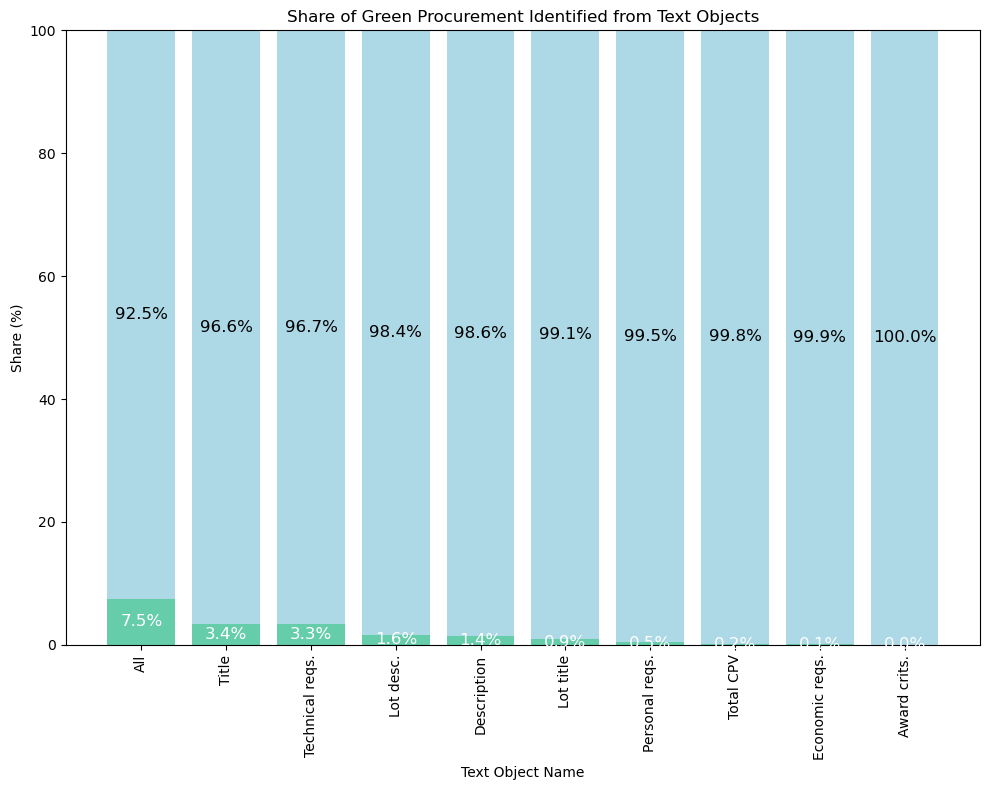

In [71]:
green_cols = [col for col in data_proc_wcleantext.columns if "green_pp" in col]
green_cols_clean = ["Title", "Description", "Personal reqs.", "Economic reqs.", "Technical reqs.", "Award crits.", "Lot title", "Lot desc.", "All"]
dummy_data = pd.DataFrame({"colname": green_cols, "colname_clean": green_cols_clean})
dummy_data.set_index("colname", inplace=True)

for col in green_cols:
    freq = data_proc_wcleantext[col].sum()
    dummy_data.loc[col, "freq"] = freq

dummy_data.sort_values(by="freq", ascending=False, inplace=True)
green_share = data_proc_wcleantext["green_pp_dummy"].sum() / len(data_proc_wcleantext) * 100
non_green_share = 100 - green_share

# Calculate share in dummy_data
dummy_data["share"] = dummy_data["freq"] / len(data_proc_wcleantext) * 100

# Create a new dataframe for CPV
cpv_data = pd.DataFrame({"colname_clean": ["Total CPV"], "share": [0]})
cpv_data.loc[0, "share"] = data_proc_wcleantext["main_cpv_full"].str.contains('|'.join(green_cpv_dict.keys()), na=False).sum() / len(data_proc_wcleantext) * 100

# Concatenate dummy_data and cpv_data
combined_data = pd.concat([dummy_data, cpv_data])

combined_data.sort_values(by="share", ascending=False, inplace=True)  # Sort by share in descending order

fig, ax1 = plt.subplots(figsize=[10, 8])

sns.barplot(x=combined_data["colname_clean"],
            y=combined_data["share"],
            color="lightblue",
            ax=ax1)

ax1.set_ylabel("Share (%)")
ax1.set_xlabel("Text Object Name")
ax1.set_title("Share of Green Procurement Identified from Text Objects")
ax1.tick_params('x', labelrotation=90)

# Iterate over each bar in the barplot
for i, (index, row) in enumerate(combined_data.iterrows()):
    green_share = row["share"]
    non_green_share = 100 - green_share

    # Plot green share
    ax1.bar(i, green_share, color="mediumaquamarine")

    # Plot non-green share
    ax1.bar(i, non_green_share, bottom=green_share, color="lightblue")

    # Annotate green share
    ax1.annotate(f"{green_share:.1f}%", xy=(i, green_share / 2), ha="center", va="center", color="white", fontsize=12)

    # Annotate non-green share
    ax1.annotate(f"{non_green_share:.1f}%", xy=(i, green_share + non_green_share / 2), ha="center", va="center", color="black", fontsize=12)

# Update x-axis ticks and labels
x_ticks = list(combined_data["colname_clean"])
ax1.set_xticks(range(len(x_ticks)))
ax1.set_xticklabels(x_ticks, rotation=90)

# Set y-axis limits to range from 0 to 100
ax1.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('green_procurement_shares.png')

### Figure 3: Contract value share of top 10 CPV sectors with Green Public Procurement contracts

In [72]:
data_proc_wcleantext = pd.read_csv("bg_cri_processed_green_pp20220426.csv",low_memory=False,
                                  dtype = {"bidder_id": object, "buyer_id": object})

In [73]:
f3_d2 = (data_proc_wcleantext
         .groupby(["main_cpv_div", "green_pp_dummy"])
         .agg({"lot_id": "count", "bid_price": "sum", "singleb": "mean"})
         .reset_index()
         .pivot(index="main_cpv_div", columns="green_pp_dummy", values=["lot_id", "bid_price"])
         .reset_index())

# Adjust the column names based on the columns present in f3_d2
f3_d2.columns = ["main_cpv_div", "count_other", "count_green", "contract_value_other", "contract_value_green"]
f3_d2["singleb"] = data_proc_wcleantext.groupby(["main_cpv_div", "green_pp_dummy"])["singleb"].mean().reset_index(drop=True)
f3_d2["volume_share_green"] = f3_d2["count_green"] / (f3_d2["count_green"] + f3_d2["count_other"])
f3_d2["volume_share_nogreen"] = 1 - f3_d2["volume_share_green"]
f3_d2["value_share_green"] = f3_d2["contract_value_green"] / (f3_d2["contract_value_green"] + f3_d2["contract_value_other"])
f3_d2["value_share_nogreen"] = 1 - f3_d2["value_share_green"]
f3_d2.sort_values(by="value_share_green", ascending=False, inplace=True)
f3_d2.reset_index(inplace=True, drop=True)
f3_d2 = f3_d2.iloc[:10]

In [74]:
print(f3_d2)

   main_cpv_div  count_other  count_green  contract_value_other  \
0          90.0       2638.0        572.0          1.117301e+09   
1          45.0      13948.0       4461.0          1.675631e+10   
2          71.0       7011.0       3649.0          1.679771e+09   
3          41.0        430.0          3.0          4.596928e+07   
4          70.0        174.0         73.0          1.776845e+07   
5          50.0       7748.0        275.0          1.855774e+09   
6          77.0       1717.0        117.0          1.779531e+08   
7          48.0       1183.0         25.0          6.037233e+08   
8          75.0        104.0          3.0          4.027438e+07   
9          76.0         36.0          1.0          1.890653e+07   

   contract_value_green   singleb  volume_share_green  volume_share_nogreen  \
0          6.779266e+08  0.355932            0.178193              0.821807   
1          8.621056e+09  0.437500            0.242327              0.757673   
2          6.092845e+08  

In [75]:
f3_d2["main_cpv_div"] = f3_d2["main_cpv_div"].replace(
{
    90: "Sewage-, refuse-, cleaning-, ... services",
    45: "Construction work",
    71: "Architectural, construction, ... services",
    41: "Collected and purified water",
    70: "Real estate services",
    50: "Repair and maintenance services",
    77: "Agricultural, forestry ... services",
    48: "Software package and information systems",
    75: "Administration, defence ... services",
    76: "Services related to the oil and gas industry"
}
)

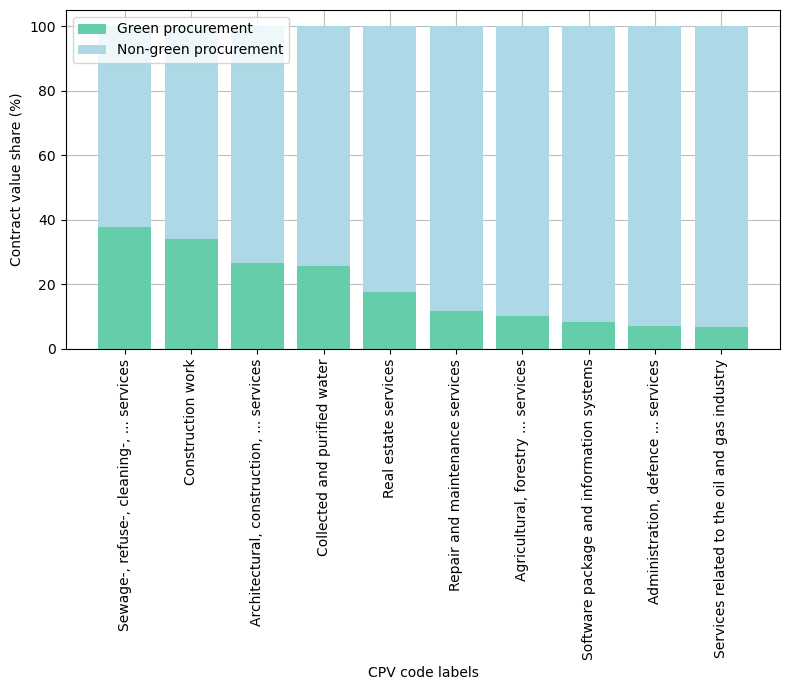

In [76]:
fig, ax = plt.subplots(figsize=[8, 7])

# Sort the dataframe by value_share_green in descending order
f3_d2_sorted = f3_d2.sort_values("value_share_green", ascending=False)

# Select the top 10 main_cpv_div based on overall contract value share
top_10_cpv_div = f3_d2_sorted.head(10)["main_cpv_div"]

# Calculate the positions for the bars
positions = np.arange(len(top_10_cpv_div))

# Your existing bar plots
ax.bar(positions, f3_d2_sorted.loc[f3_d2_sorted["main_cpv_div"].isin(top_10_cpv_div), "value_share_green"]*100, label="Green procurement", color="mediumaquamarine")
ax.bar(positions, f3_d2_sorted.loc[f3_d2_sorted["main_cpv_div"].isin(top_10_cpv_div), "value_share_nogreen"]*100,
       bottom=f3_d2_sorted.loc[f3_d2_sorted["main_cpv_div"].isin(top_10_cpv_div), "value_share_green"]*100, label="Non-green procurement", color="lightblue")

ax.tick_params('x', labelrotation=90)
ax.set_xticks(positions)
ax.set_xticklabels(top_10_cpv_div)

ax.set_xlabel("CPV code labels")
ax.set_ylabel("Contract value share (%)")

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', alpha=0.5)
ax.xaxis.grid(color='gray', alpha=0.5)


# Display legends
ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig('top10_cpv_dist_share_1.png', bbox_inches='tight')
plt.show()